# Build Hyetographs from DSS Outputs

In [1]:
import os
import subprocess
import numpy as np
import pandas as pd
from skimage.io import imsave, imread 
from skimage.viewer import ImageViewer
import pysal
import geopandas as gpd
from matplotlib import pyplot as plt
% matplotlib inline
from plotly_utils import *

C:\Users\slawler\AppData\Local\Continuum\Anaconda3\lib\site-packages\skimage\viewer\utils\core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "


## Read in DSS data for models within the 2D domain

In [2]:
model_group = 3

model_dir = r'C:\Users\slawler\Desktop\Models\RainOnGrid\G{}'.format(model_group)
dss_dir = r'C:\Users\slawler\Desktop\Models\RainOnGrid\DSS'
gage_file = r'C:\Users\slawler\Desktop\Models\area_shapefiles\usgs_gages.shp'

gages = gpd.read_file(gage_file )

basin_file =os.path.join(model_dir, 'HMS', 'shapefiles', 'G{}_Basins.dbf'.format(model_group) )
basin_shape_file = os.path.join(model_dir, 'HMS', 'shapefiles', 'G{}_Basins.shp'.format(model_group))
domain_2d_file = os.path.join(model_dir, 'HMS', 'shapefiles', 'G{}_domain.shp'.format(model_group))

dbf = pysal.open(basin_file)
d = {col: dbf.by_col(col) for col in dbf.header}
basins = pd.DataFrame(d)
basins.head(2)

model_group_basins = list(basins['SUBBASIN'].unique())

dss_files = list(basins['WTSHUNIT'].unique())
print('Model Gorup ', model_group, '\nDSS Files: ', dss_files)

Model Gorup  3 
DSS Files:  ['J']


## Filter DSS Group to select only basins within the 2D domain

In [3]:
for i, dss_group in enumerate(dss_files):
    data_file = os.path.join(dss_dir ,'{}.xlsx'.format(dss_group))
    data=pd.read_excel(os.path.join(model_dir, data_file), 
                       sheetname='Sheet1', skiprows=1, infer_datetime_format=[0])
    print(data_file, data.shape)
    data.drop(axis=0, labels=list(range(0,5)), inplace=True)
    data.rename(columns={'Unnamed: 1':'Date'}, inplace=True)
    data.drop(axis=1, labels='B', inplace=True)
    data.set_index('Date', inplace=True)
    data.index.name=None
    data.head()
    
    if i == 0:
        dss_data=data.copy()
    else:
        dss_data = pd.merge(dss_data, data, left_index=True,right_index=True)
        
dss_data.head(2)

C:\Users\slawler\Desktop\Models\RainOnGrid\DSS\J.xlsx (548, 36)


,J100A,J100B,J100C,J100D,J100E,J100F,J100G,J100H,J100I,J100J,...,J501A,J501B,J502A,J502B,J503A,J503B,J504,J601A,J601B,J602
2017-08-25 05:15:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-08-25 05:30:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Average Excess Precipitation for selected basins, write to file 

In [4]:
df  = dss_data[model_group_basins].copy()

# Print shapes to verify selection, check df.shape again
df  = dss_data[model_group_basins].copy()
PlotHyetograph(df, df.columns, 'Inches', output_dir=None,  model='G0 All Basins', notebook=True)
      
df['Mean'] = df.mean(axis=1)
df['Mean'].to_csv(os.path.join(model_dir, 'G{}_MeanExcess.csv'.format(model_group)))

df['Min'] =df.min(axis=1)
df['Max'] =df.max(axis=1)
df['Total'] = dss_data.sum(axis=1)

stats = df[['Min', 'Mean', 'Max']].copy()
stats_w_total = df[['Min', 'Mean', 'Max', 'Total']].copy()

PlotHyetograph(stats, stats.columns, 'Inches', output_dir=None,  model='G0 Statistical Summary', notebook=True)
PlotHyetograph(stats_w_total, stats_w_total.columns, 'Inches', output_dir=None,  model='G0 With Total', notebook=True)

df.head(2)

,J100G,J100H,J100I,J100J,J101A,J101B,J201,Mean,Min,Max,Total
2017-08-25 05:15:00,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0
2017-08-25 05:30:00,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0


## Buffer selected basins to develop 2D Mesh

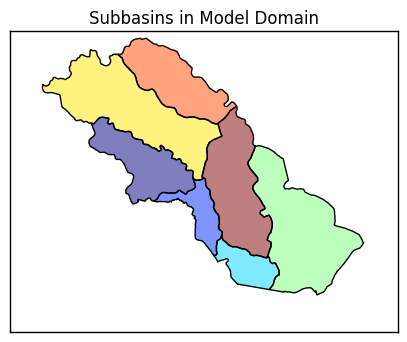

In [5]:
gdf = gpd.read_file(basin_shape_file)
ras_domain = gdf.buffer(100).unary_union
add_index = gdf.shape[0]
ax = gdf.plot(figsize=(5,5))
plt.title('Subbasins in Model Domain')
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)

File written to  C:\Users\slawler\Desktop\Models\RainOnGrid\G3\HMS\shapefiles\G3_domain.shp


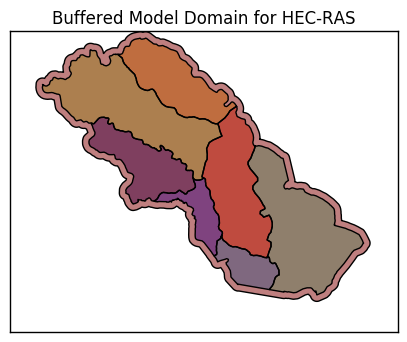

In [6]:
ras_domain = gdf.buffer(1500).unary_union
gdf = gdf.append({'SUBBASIN': "RAS", 'WTSHNAMW': "NA","WTSHUNIT": "A", 'geometry': ras_domain }, 
            ignore_index=True)
gdf.plot(figsize=(5,5))
plt.title('Buffered Model Domain for HEC-RAS')
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)

domain_shape = gdf[gdf['SUBBASIN']=='RAS'].copy()
domain_shape.to_file(domain_2d_file)

print("File written to ", domain_2d_file)

## Build & Run HEC-RAS Model 

### Clip raster when complete

In [7]:
mask_poly = basin_shape_file 
ras_depth_grid = str('"{}"'.format(os.path.join(model_dir, 'RAS', 'G{}'.format(model_group),
                             'Depth (Max).usgs_dem_ft.tif')))

clipped_ras_depth_grid = str(os.path.join(model_dir, 'RAS', 'G{}'.format(model_group),
                             'G{}_depth.tif'.format(model_group)))

gdal_clip = "gdalwarp -ot Float32 -of GTiff -cutline {} -crop_to_cutline {} {}".format(mask_poly, ras_depth_grid, clipped_ras_depth_grid)
with open(os.path.join(model_dir, 'clip_raster.cmd'), 'w') as f:f.write(gdal_clip)
subprocess.call(os.path.join(model_dir, 'clip_raster.cmd'), shell=True)
print('Depth Grid clipped ', clipped_ras_depth_grid)

Depth Grid clipped  C:\Users\slawler\Desktop\Models\RainOnGrid\G3\RAS\G3\G3_depth.tif


## Take a peak at the output

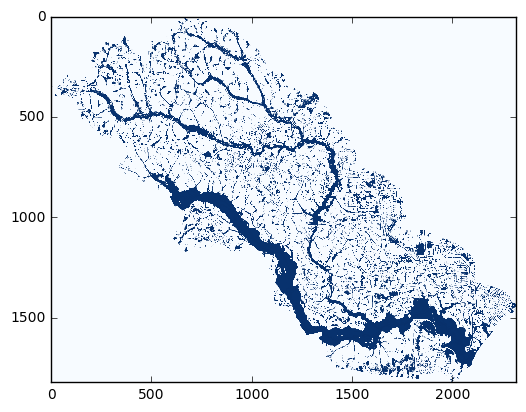

In [8]:
f, (ax1) = plt.subplots()
f.set_size_inches(6,6)
ax1.imshow(imread(clipped_ras_depth_grid), cmap=plt.cm.Blues)

# Evaluate Results

### Plot Gages in Domain

In [9]:
gages = gages.to_crs(gdf.crs)
model_domain = gdf[gdf['SUBBASIN']=='RAS'].geometry
domain_gages = set()
for j, gage in enumerate(gages.index):
    point_location = gages.iloc[j]['geometry']
    gage_name = gages.iloc[j]['Site_Numbe']
    if point_location.intersects(model_domain.iloc[0]):
        domain_gages.add(gage_name)
        print(gage_name)       

08068390
08068400
08068450
08068500
08068500


## Enter Gage to Plot

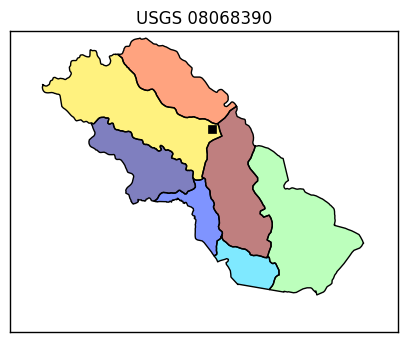

In [10]:
gage_id ='08068390'

gdf = gpd.read_file(basin_shape_file)
ax = gdf.plot(figsize=(5,5))
gage = gages[gages['Site_Numbe'] == gage_id].copy()
gage.plot(ax=ax, markersize=6, marker='s',color='Black')
plt.title('USGS {}'.format(gage_id))
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)

In [11]:
gage_type = 'inst_flow'
gage_dir = r'T:\CCSI\TECH\2018_HoustonCity\GIS\DATA\Gages\GageData\PROCESSED\WORKING'
ras_dir = r'C:\Users\slawler\Desktop\Models\RainOnGrid\G0\RAS\Features'

g = pd.read_csv(os.path.join(gage_dir,'{}.csv'.format(gage_type)), parse_dates=[0])
g.rename(columns={'Unnamed: 0':'Date'},inplace=True)
g.set_index('Date', inplace=True)
g.index.name=None

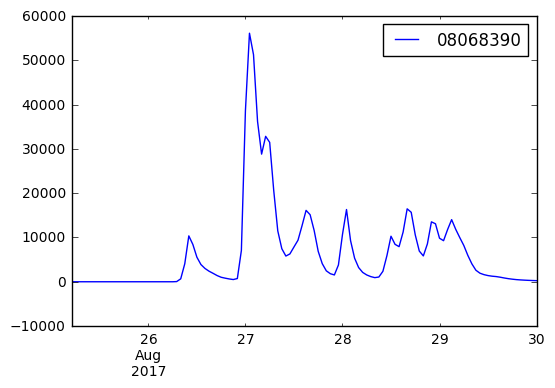

In [13]:
#ras_at_gage = os.path.join(ras_dir, 'ras_at_{}.txt'.format(gage))
ras_at_gage = os.path.join(ras_dir, 'N1.txt')
df_gage = pd.DataFrame(g[gage_id]).copy()
df_ras = pd.read_csv(ras_at_gage, sep='\t', 
                     header=None, infer_datetime_format=[0])

dtm = pd.to_datetime(df_ras[0], format='%d%b%Y %H:%M:%S')
df_ras.set_index(dtm,inplace=True)
df_ras.rename(columns={1:gage_id}, inplace=True)
df_ras.index.name=None
df_ras.drop(axis=1, labels=0, inplace=True)
df_ras.head()

#Gage_Validation_Plot(df_ras, df_gage, gage, xlabel = None, 
#                     ylabel = 'Flow (cfs)', title = gage, notebook=True)
df_ras.plot()